# PW 2 - Bayesian analysis with MRF
For this part we will perform the binary classification of a grayscale image **_Iobservee_** (image of the observations, realization $y$ of the field $Y$) using a Markovian model. 

In this ideal case, we are given the ideal solution $x$ (binary image **_IoriginalBW_**), realization of the field of classes $X$, which will be used to evaluate the quality of the solution $\hat{x}$ that we will have obtained. (NB: In practice usually, we don't have access to $x$). 

In this part we will use the **_display_** function to visualize the images.

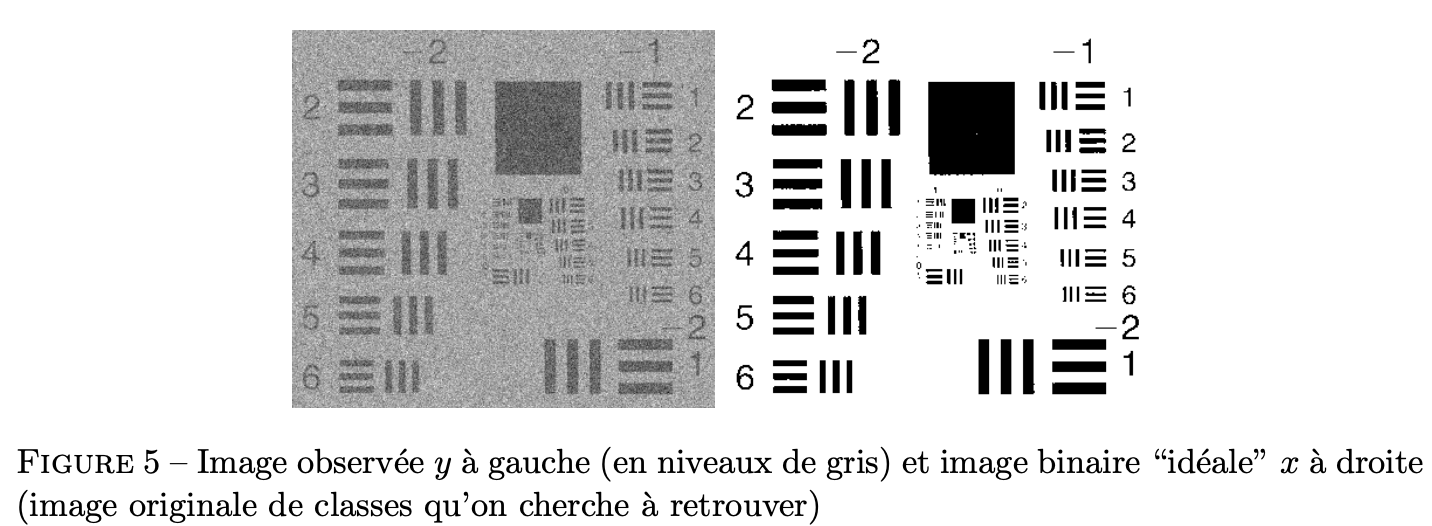

In [1]:
import math
import random
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
import imageio
from scipy import ndimage as ndi
from skimage import io

from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

In [89]:
def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
    def normalise_image_pour_bokeh(X,MINI,MAXI):
        if MAXI==None:
            MAXI = np.max(X)
        if MINI==None:
            MINI = np.min(X)
        imt=np.copy(X.copy())
        imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
        imt[imt<0]=0
        imt[imt>1]=1
        imt*=255
        sortie=np.empty((*imt.shape,4),dtype=np.uint8)
        for k in range(3):
            sortie[:,:,k]=imt
        sortie[:,:,3]=255
        return sortie

    img = im
    img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]])
    # p.x_range.range_padding = p.y_range.range_padding = 0
    # must give a vector of images
    p.image(image=[np.flipud(im)], x=0, y=im.shape[0], dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
    p.xgrid.visible = False
    p.ygrid.visible = False
    showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
    affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

The scikit-image library allows to read images from a URL. The "display" function allows to access directly to the grey levels and to the pixels positions by using the mouse.

In [90]:
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png")

affiche(im_obs)

In [91]:
im_ori=imageio.imread('https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png')

affiche(im_ori)

The objective is to estimate $x$ from y using a prior on $P(X)$ in the form of a Markovian model. 
We note $x_s$ the class of the pixel $s$ (that we are looking for), and $y_s$ the observed gray level. The objective is to use a global model on the random field $X$ to classify the image. As we have seen in class, this amounts to minimizing the following energy:

$$U(x|y)=\sum_s -ln(P(Y_s=y_s |X_s=x_s))+\sum_c U_c(x_s, s\in c)$$ 

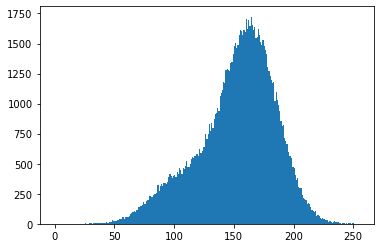

In [92]:
#study of the global distribution of the image
#display of the histogram of the image 
plt.figure()
plt.hist(im_obs.ravel(),range=[0,np.max(im_obs)],bins=np.max(im_obs))
plt.show()

## 1. Analysis of the gray level distributions
In this part, we learn the probabilities $P(Y_s=y_s |X_s)$, that is to say $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. This is equivalent to studying the histogram of gray levels of pixels that are in class 0 and pixels that are in class 1.  


To perform this training, we need to select pixels belonging to class 0 on the one hand (dark area of the observed image), and pixels belonging to class 1 on the other hand (light area of the observed image). 

We can select pixels manually, using the command `v0=I[i1:i2,j1:j2]` in Python which puts in a vector all the values of the pixels of the image $I$ included between the indices $i1$ and $i2$ (rows), and $j1$ and $j2$ (columns).

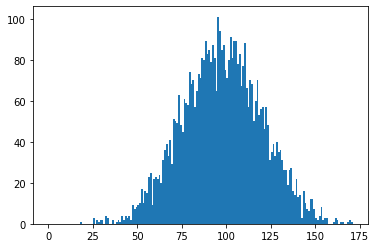

In [93]:
#select a small window in a dark region of the image (class 0)
#be careful, the ordinates correspond to the rows and the abscissas to the columns
crop_classe0=im_obs[50:120,175:245]
#visualise the window
affiche(crop_classe0)
#plot its histogram
plt.figure()
plt.hist(crop_classe0.ravel(),range=[0,np.max(crop_classe0)],bins=np.max(crop_classe0))
plt.show()

In [94]:
#calculate its mean and variance
#
# By default, np.mean, np.zzz takes the two axes of the image. 
# You have to force the option if you want to do the average in row or in column
# use np.mean and np.var
m0=crop_classe0.mean()
var0=crop_classe0.var()

print(m0)
print(var0)

97.19183673469388
501.04891295293623


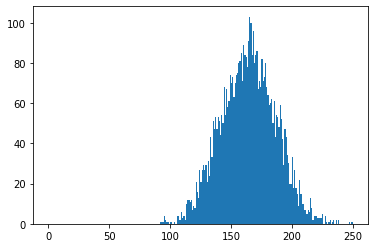

In [95]:
#select a small window in a dark region of the image (class 1)
crop_classe1=im_obs[230:300,130:200]
affiche(crop_classe1)
#plot its histogram
plt.figure()
plt.hist(crop_classe1.ravel(),range=[0,np.max(crop_classe1)],bins=np.max(crop_classe1))
plt.show()

In [96]:
#calculate its mean and variance
m1=crop_classe1.mean()
var1=crop_classe1.var()

print(m1)
print(var1)

163.87755102040816
512.7315368596419


### Q1
What are the distributions followed by the grey levels in these two classes? Give the means and variances of the two classes that you have estimated. 

### A1

The followed distributions by the grey levels in these two classes is the gaussian distribution.
 
For classe 0 we have : 
* mean : 97
* var : 501

For classe 1 : 
* mean : 163
* var : 512


### Q2
In the following, the variances will be assumed to be equal in order to simplify the energy expressions. 

Suppose that we do not use a Markov model on $X$ and that we classify a pixel only according to its grey level by comparing $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$. Show that this amounts to thresholding the image and give the value of the optimal threshold as a function of the parameters found previously (we say that we are doing a classification by punctual maximum likelihood).

### A2

Since the following distribution by $P(Y_s=y_s |X_s=0)$ and $P(Y_s=y_s |X_s=1)$ is gaussian we have : 

$P(Y_s=y_s |X_s=0) = \frac{1}{\sqrt{2\pi\sigma}}e^{\frac{(x-\mu_{0})^2}{2\sigma_{0}^2}}$

and

$P(Y_s=y_s |X_s=1) = \frac{1}{\sqrt{2\pi\sigma}}e^{\frac{(x-\mu_{1})^2}{2\sigma_{1}^2}}$

The threshold can be define as the intersection of the 2 gaussians : 

$P(Y_s=y_s |X_s=0)  = P(Y_s=y_s |X_s=1) \Leftrightarrow  e^-\frac{1}{2}\frac{(x-\mu_{0})^2}{\sigma_{0}^2} = e^-\frac{1}{2}\frac{(x-\mu_{1})^2}{\sigma_{1}^2}$
$\Leftrightarrow (x-\mu_{0})^2 = (x-\mu_{1})^2 \Leftrightarrow x - \mu_{0} = \frac{+}{-} (x - \mu_{1})$

If + :  $\mu_{0} = \mu_{1}$

If - :  $2x = \mu_{0} + \mu_{1} \Leftrightarrow x = \frac{\mu_{0} + \mu_{1}}{2}$

So if the variances are equal we can find the threshold x by the mean of the Gaussian means

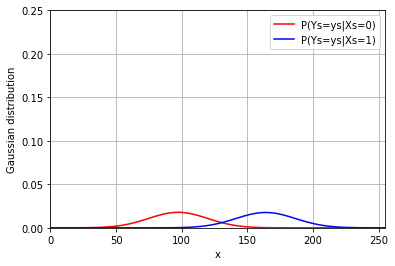

threshold :  130.53469387755104


In [97]:
# Set the threshold for classification in the ML sense and display the image

from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

# plot gaussian
x_min = 0.0
x_max = 255.0
x = np.linspace(x_min, x_max, 100)
y = scipy.stats.norm.pdf(x,m0,np.sqrt(var0))
plt.plot(x,y, color='red')
x1 = np.linspace(x_min, x_max, 100)
y1 = scipy.stats.norm.pdf(x,m1,np.sqrt(var1))
plt.plot(x1,y1, color='blue')
plt.grid()
plt.xlim(x_min,x_max)
plt.ylim(0,0.25)
plt.legend(["P(Ys=ys|Xs=0)", "P(Ys=ys|Xs=1)"])
plt.xlabel('x')
plt.ylabel('Gaussian distribution')
plt.savefig("normal_distribution.png")
plt.show()

# threshold computation
threshold=(m0+m1)/2 
print("threshold : ", threshold)

# rough initialization for ICM
im_init = np.where(im_obs > threshold, 1, 0)
im_bin=im_obs.copy()
affiche(im_init)

###Q3
From the results found for $P(Y_s=y_s |X_s)$, write the likelihood energy (data attachment): $$U_{attdo}=\sum_s -ln(P(Y_s=y_s |X_s=x_s))$$ 

###A3
 
$$U_{attdo}=\sum_s -ln(P(Y_s=y_s |X_s=x_s)) = K + \frac{1}{2\sigma^2}\sum_{s \in S}(ys-\mu_{xs})^2$$ 

With $K =\sum_{s\in S} ln(σ)$ 

## 2 Ising model for regularisation and energies
To improve the thresholding results, it is necessary to introduce a regularisation (global prior model).

### Q4
Consider the function $\Delta(x_s,x_t)=0$ if $x_s=x_t$, and $\Delta(x_s,x_t)=1$ otherwise. Write the second-order clique potential for this Ising model as a function of $\Delta(x_s,x_t)$ where $x_s$ and $x_t$ are the classes of neighbouring pixels $s$ and $t$ in 4-connexity and the regularisation parameter $\beta$. This model will be 0 when the two neighbouring pixels are equal and $+\beta$ otherwise. 
Write the global energy of the whole field and the local conditional energy for a site 𝑠 using the results previously established for the data attachment energy and the regularization energy defined previously. 

Reminder: the global energy contains all the cliques in the image, the local conditional energy at a site 𝑠 contains only the cliques that contain 𝑠.

Tip: the energy is defined to within one additive constant and one multiplicative constant (the minimum of K+K'U is equivalent to the minimum of U). It is better to simplify the writing of the energy as much as possible in order to do the programming afterwards.

### A4
With the simplified expression (because of the same variance) we have :

- _global energy_: 
$U(X|Y) = \sum_{s \in S}\frac{(ys-\mu_{xs})^2}{2\sigma_{xs}^2} + ln(\sigma_{xs}) + \sum_{c= \{s,t\}} βΔ(xs,xt)$

$\Leftrightarrow
\sum_{s \in S}(ys-\mu_{xs})^2 + ln(\sigma_{xs}) + \sum_{c= \{s,t\}} 2\sigma_{xs}^2 βΔ(xs,xt)
= \sum_{s \in S}(ys-\mu_{xs})^2 + ln(\sigma_{xs}) + \sum_{c= \{s,t\}} β'Δ(xs,xt)
$
$\Leftrightarrow
\sum_{s \in S}(ys-\mu_{xs})^2 + \sum_{c= \{s,t\}} β'Δ(xs,xt)
$

With $β' = 2\sigma_{xs}^2 β$

- _local conditional energy_:
$U(x_{s}|y_{s}, x_{t}, t \in V_{s}) = \frac{(ys-\mu_{xs})^2}{2\sigma_{xs}^2}+ ln(\sigma_{xs}) + \sum_{t \in Vs} βΔ(xs,xt)$

$\Leftrightarrow
(ys-\mu_{xs})^2+ ln(\sigma_{xs}) + \sum_{t \in Vs} 2\sigma_{xs}^2 βΔ(xs,xt)
= (ys-\mu_{xs})^2+ ln(\sigma_{xs}) + \sum_{t \in Vs}β'Δ(xs,xt)
$
$\Leftrightarrow
(ys-\mu_{xs})^2+ \sum_{t \in Vs}β'Δ(xs,xt)
$

With $β' = 2\sigma_{xs}^2 β$

### Q5
Write the local conditional energies for classes 0 and 1 of the central pixel, using the following local neighbourhood configuration: neighbours in states 0, 1, 1, 1, and assuming that the grey level of the pixel is $y_s=105$, and using the mean and variance values found previously.

### A5

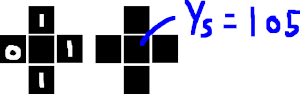

For $\sigma_{xs=0} = \sigma_{xs=1} = \sqrt 501$ :

$U(x_{s}=0|y_{s}, x_{t}, t \in V_{s}) = \frac{(ys-\mu_{xs=0})^2}{2\sigma_{xs=0}^2}+ ln(\sigma_{xs=0}) + \sum_{t \in Vs} βΔ(xs=0,xt) = \frac{(105-97)^2}{2*501} + ln(\sqrt{501}) + 3β \Leftrightarrow \frac{(105-97)^2}{2*501} + 3β = 0.06 + 3β$

$U(x_{s}=1|y_{s}, x_{t}, t \in V_{s}) = \frac{(ys-\mu_{xs=1})^2}{2\sigma_{xs=1}^2}+ ln(\sigma_{xs=1}) + \sum_{t \in Vs} βΔ(xs=1,xt) = \frac{(105-163)^2}{2*501} + ln(\sqrt{501}) + 3β \Leftrightarrow \frac{(105-163)^2}{2*501} + 3β = 1.62 + β$

### Q6
In which class will this pixel be put if it is assigned the class that locally minimises energy?

### A6
For classe 0 we have a small likelihood and the  neighbours don't really like this solution.

For classe 1 we have an higher likelihood and the  neighbours like this solution.

The class in which the pixel must be put depends on the value of β : 

if 0.0638 + 3β < 3.357 + β $\Leftrightarrow$ β $\leq \frac{3.357-0.0638}{2}=1.646$ then the pixel must be put to class 0.

### Q7
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is 0 ?

### A7

When β = 0 we have : 

$U(X|Y) = \sum_{s \in S}\frac{(ys-\mu_{xs})^2}{2\sigma_{xs}^2} + ln(\sigma_{xs}) + \sum_{c= \{s,t\}} βΔ(xs,xt) = \sum_{s \in S}\frac{(ys-\mu_{xs})^2}{2\sigma_{xs}^2} + ln(\sigma_{xs})$
$\Leftrightarrow
\sum_{s \in S}\frac{(ys-\mu_{xs})^2}{2\sigma_{xs}^2}
$

The solution will correspond to the punctual bayesian classifier, it's the global energy without the regularization term. As β=0 the pixel will be put to class 0.

### Q8
Considering the ***global*** energy of the field, what is the solution $x$ when $\beta$ is $+\infty$ ?

### A8

When β is $+\infty$ :

$U(X|Y)  \simeq \sum_{c= \{s,t\}} βΔ(xs,xt)$

The global energy will be almost completly equal to the regularisation term, this means that we no longer have the likelohood term, we came back to the state of the first praticals. As β is huge, the pixel will be put at the class 1. We will tends to have a uniform image.


### Q9
How will the solution vary when $\beta$ increases ? Comment on the interest of this Markovian model. 

### A9
At start when β is small, the likelihood term will be important, as β increase the more the opinion of the neighboors will be important, the image will be more and more regular.

## 3. Optimisation by ICM algorithm
We will optimise the global energy defined above, using the ICM (Iterated Conditional Modes) algorithm which consists of minimising the local conditional energy of the pixels one after the other, starting from a good initialisation of the classes. This algorithm converges to a local minimum but is very fast.  
 
Complete the **iter_icm** function to program the ICM, taking into account the data attachment term you have learned.

### ICM function 
Using what you did for the Gibbs sampler, complete the following function to perform one iteration of the Iterated Conditional Modes algorithm (one pass over all pixels in the image). 

In [98]:
def iter_icm(im_bin,im_toclass,beta_reg,m0,m1):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):
            # do not change these indices they allow access to neighboring pixels  
            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            # energy computation if the pixel is put in class 0
            Ureg0= (im_bin[i1,j] + im_bin[i,j2] + im_bin[i2,j] + im_bin[i,j1])*beta_reg # betaprim
            U0= (im_toclass[i,j]-m0)**2 + Ureg0

            # energy computation if the pixel is put in class 1
            Ureg1= (4-(im_bin[i1,j] + im_bin[i,j2] + im_bin[i2,j] + im_bin[i,j1]))*beta_reg
            U1= (im_toclass[i,j]-m1)**2 + Ureg1
 
            if (U0 < U1):
                im_bin[i,j]= 0
            else :
                im_bin[i,j]= 1
    return im_bin


### Q10
What do you suggest to have a good initialization of the solution? Justify your answer.

###A10

We can use the thresholded image with the intersection of the gaussian that create roughly 2 classes, we will have a rough initialization for ICM, that will be regularize this initialization iteration after iteration.

Implement the ICM and study the influence of $\beta$.

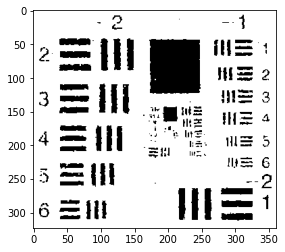

In [99]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg= 2000

#initialise the binary image of the classes 
im_bin = im_init

affiche(im_bin)
# program a loop in which we call iter_icm 
# and display the class image as iterations are performed 
for n in range(20):
    im_bin = iter_icm(im_bin,im_obs,beta_reg,m0,m1)
plt.imshow(im_bin, cmap='gray')
plt.show()

### Q12
With what value of $\beta$ do you get a good solution (i.e. the closest to the given "ideal" image **IoriginaleBW.png**). Compare this result with the result of the optimal thresholding.

###A12

We can make a plot of the number of white pixel in the difference image (that we want to minimise) in function of different values of beta.

You can compare your result with the original image to find the right regularisation parameter. 

In [100]:
#use np.abs to calculate the absolute value of the difference 
# between the original binary image and the ICM result
# note: im_bin is coded between 0 and 1 and im_ori between 0 and 255

ima_diff=np.abs(im_bin - im_ori/255)
affiche(ima_diff)

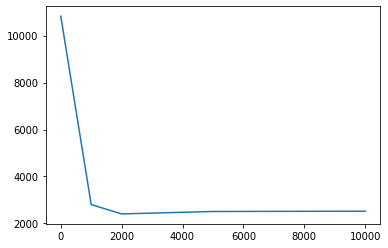

In [48]:
# beta opti
beta_reg_l = [1, 1000, 2000, 5000, 10000]

whites = []
for beta_reg in beta_reg_l:
  #initialise the binary image of the classes 
  
  im_bin = im_init.copy()
  # another initialisations
  #im_bin = np.random.random((im_ori.shape)).astype(np.float32) #random image init 
  #im_bin = np.zeros((im_ori.shape))*255 #another image init
  #im_bin = np.ones((im_ori.shape))*255 #another image init
  #im_bin = np.hstack((np.ones((im_ori.shape[0], im_ori.shape[1]//2)),np.zeros((im_ori.shape[0], im_ori.shape[1]//2 +1))))
  
  # program a loop in which we call iter_icm 
  # and display the class image as iterations are performed 
  for n in range(20):
      im_bin = iter_icm(im_bin,im_obs,beta_reg,m0,m1)
  ima_diff=np.abs(im_bin - im_ori/255)
  nb_white = np.where(ima_diff==1, 1,0).sum()
  whites.append(nb_white)

plt.plot(np.array(beta_reg_l), np.array(whites))

In [27]:
beta_prim_opti = 2000
beta_reg_opti = beta_prim_opti/(2*var0) #  β' = 2*var0* β <=>  β =  β' / 2*var0 
print("β'* = ", beta_prim_opti)
print('β* = ', beta_reg_opti)

β'* =  2000
β* =  1.995813131509439


For the rought initialisation : 

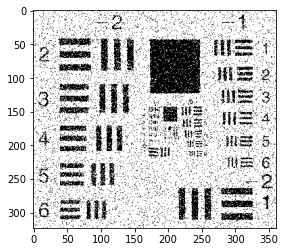

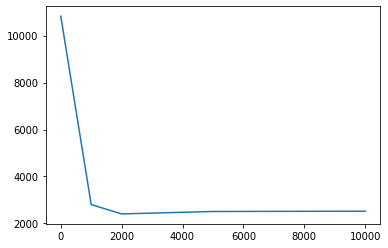

We see on this plot that the β' optimal seems to be arround 2000 so : 

$β'^* = 2σ_{xs}β^*$ with $σ_{0}=σ_{1}$ here, we have 
$β'^* = 2σ_{0}β^* \Leftrightarrow β^*= \frac{β'^*}{2*σ_{0}}$

The optimal value of $β'^*$ depend on the initialisation, we can try to find the best $β'^*$ for each initialisation. 

 For random image : 

 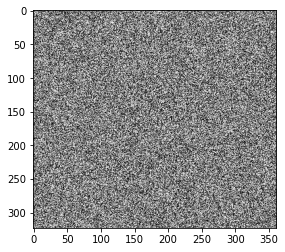

 We have $β'=2000$ :

 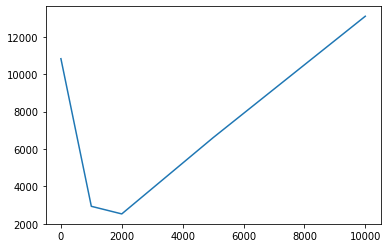

For black image :

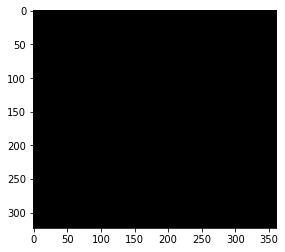

We have $β'=1000$ : 

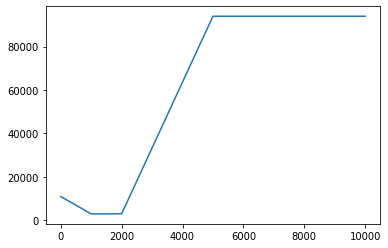

For white image : 

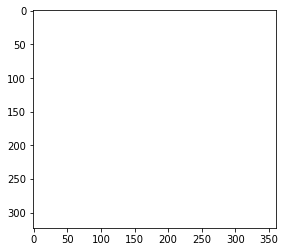

We have $β'=1000$ : 

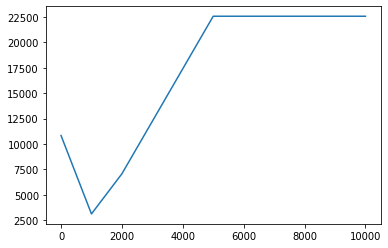

For half black/white image : 

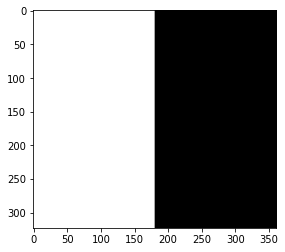

We have $β'=1000$ : 

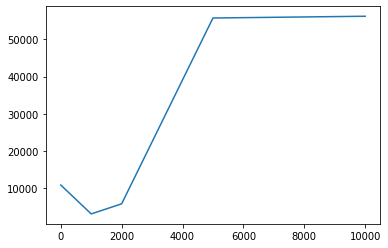

### Q13
Try with other initialisations (with a constant image, with a random image). Comment on their influence.

2000


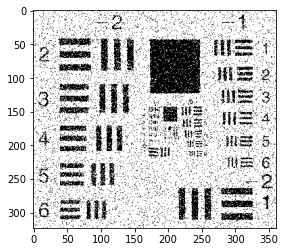

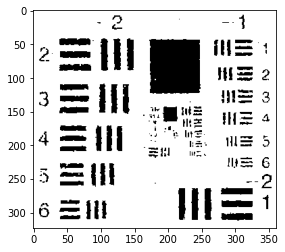

2404

In [68]:
# ICM algorithm to be implemented
#define the value of beta_reg to have a "good" regularization
beta_reg= beta_prim_opti
print(beta_reg)

#initialise the binary image of the classes 
im_init = np.where(im_obs > threshold, 1, 0)
im_bin = im_init # thresholded image init

# another init
#im_bin = np.random.random((im_ori.shape)).astype(np.float32) #random image init 
#im_bin = np.hstack((np.ones((im_ori.shape[0], im_ori.shape[1]//2)),np.zeros((im_ori.shape[0], im_ori.shape[1]//2 +1)))) #half black/white
#im_bin = np.ones((im_ori.shape))*255 #white vmin/vmax to set on the plot
#im_bin = np.zeros((im_ori.shape))*255 #black  vmin/vmax to set on the plot
plt.imshow(im_bin, cmap='gray') #plt.imshow(im_bin, cmap='gray', vmin=0, vmax=255)
plt.show()

# program a loop in which we call iter_icm 
# and display the class image as iterations are performed 
for n in range(10):
    im_bin = iter_icm(im_bin,im_obs,beta_reg,m0,m1)
plt.imshow(im_bin, cmap='gray')
plt.show()

ima_diff=np.abs(im_bin - im_ori/255)
nb_white = np.where(ima_diff==1, 1,0).sum()
nb_white

###A13

For the rough initialisation : 

* Initialisation : 

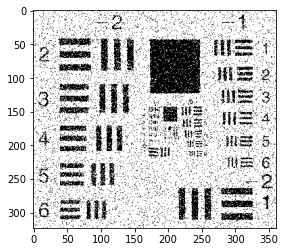

* solution : 

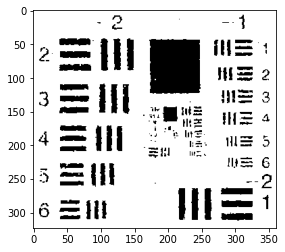

Number of white pixel on the difference image : 2404  with $β'=2000$

For the random initialisation : 

* Initialisation : 

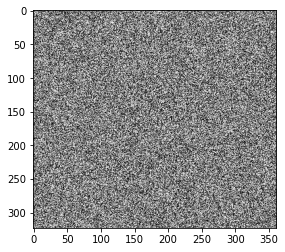

* solution :

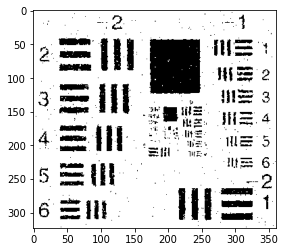

Number of white pixel on the difference image : 2937 with $β'=1000$


For half initialisation : 

* Initialisation : 

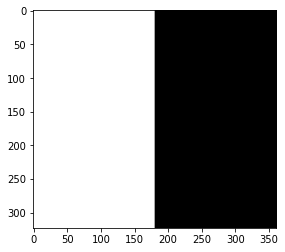

* Solution : 

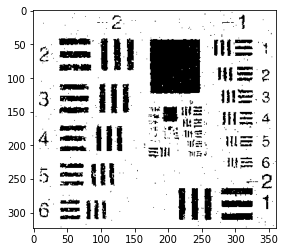

Number of white pixel on the difference image : 3055 with $β'=1000$

For the white image initialisation : 

* Initialisation : 

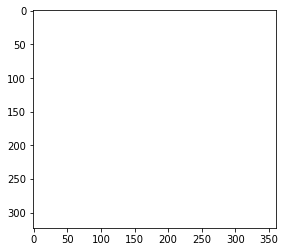

* Solution : 

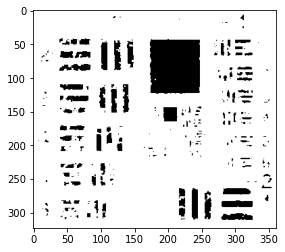

Number of white pixel on the difference image : 3115 with $β'=1000$

For black image initialisation :

* Initialisation : 

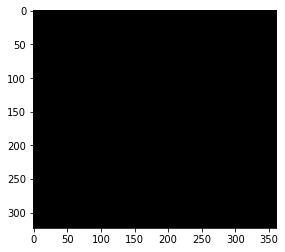

* Solution :

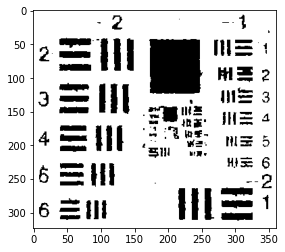


Number of white pixel on the difference image : 2806 with $β'=1000$

We can see that the initialisation have an huge impact on the result, a rought initialisation is the better option in this case.

### Simulated annealing
Program the **echan_r** function of the simulated annealing which allows to update an image by sampling with the Gibbs distribution a posteriori with a fixed temperature T.  

In [70]:
def echan_r(im_bin,im_toclass,beta_reg,m0,m1,T):

    i=0;
    j=0;

    for i in range(im_bin.shape[0]):
        for j in range(im_bin.shape[1]):

            i1=(i-1)%im_bin.shape[0]
            i2=(i+1)%im_bin.shape[0]
            j1=(j-1)%im_bin.shape[1]
            j2=(j+1)%im_bin.shape[1]

            Ureg0= (im_bin[i1,j] + im_bin[i,j2] + im_bin[i2,j] + im_bin[i,j1])*beta_reg
            U0 =  (im_toclass[i,j]-m0)**2 + Ureg0
            p0=math.exp(-U0/T);

            Ureg1= (4-(im_bin[i1,j] + im_bin[i,j2] + im_bin[i2,j] + im_bin[i,j1]))*beta_reg
            U1= (im_toclass[i,j]-m1)**2 + Ureg1
            p1=math.exp(-U1/T);

            if (p0+p1!=0.):
                if(random.uniform(0,1)<p0/(p0+p1)):
                    im_bin[i,j]=0
                else :
                    im_bin[i,j]=1

    return im_bin

Call the function echan_r iteratively, decreasing the temperature after each update slowly enough. 

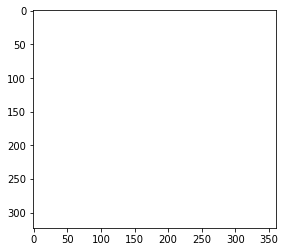

0 198.0
1 196.02
2 194.0598
3 192.119202
4 190.19800998
5 188.2960298802
6 186.413069581398
7 184.54893888558402
8 182.70344949672818
9 180.8764150017609
10 179.06765085174328
11 177.27697434322585
12 175.50420459979358
13 173.74916255379566
14 172.0116709282577
15 170.2915542189751
16 168.58863867678537
17 166.9027522900175
18 165.23372476711734
19 163.58138751944617
20 161.9455736442517
21 160.3261179078092
22 158.7228567287311
23 157.13562816144378
24 155.56427187982933
25 154.00862916103105
26 152.46854286942073
27 150.94385744072653
28 149.43441886631928
29 147.94007467765607
30 146.46067393087952
31 144.99606719157072
32 143.546106519655
33 142.11064545445845
34 140.68953899991385
35 139.28264360991471
36 137.88981717381557
37 136.51091900207743
38 135.14580981205665
39 133.7943517139361
40 132.45640819679673
41 131.13184411482877
42 129.82052567368046
43 128.52232041694367
44 127.23709721277423
45 125.96472624064648
46 124.70507897824002
47 123.45802818845762
48 122.223447906573

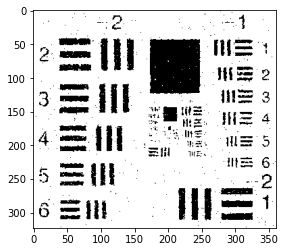

2805

In [88]:
# Program the simulated annealing 
#temperature initialization 
# initial temperature
T=200
beta_reg=1000#beta_prim_opti

#initialization of the binary image
#im_init = np.where(im_obs > threshold, 1, 0)
#im_bin = im_init.copy()
im_bin = np.ones((im_ori.shape)) #white vmin/vmax to set on the plot

plt.imshow(im_bin, cmap='gray', vmin=0, vmax=1) #plt.imshow(im_bin, cmap='gray')
plt.show()

# make a loop by calling the function that does a Gibbs sampling at T
for n in range(190):
    im_bin = echan_r(im_bin,im_obs, beta_reg,m0,m1,T)
    T*=0.99
    print(n, T)

plt.imshow(im_bin, cmap='gray')
plt.show()

ima_diff=np.abs(im_bin - im_ori/255)
nb_white = np.where(ima_diff==1, 1,0).sum()
nb_white  

###Q14
Compare the results obtained by the Iterated Conditional Modes algorithm and by simulated annealing. Do you find the results of the course ?

###A14

ICM is lot quicker because it take always the max probability, but it will fall into the closest local minima, if it's the global is perfect, otherwise the solution is not found. The simulated annealing is slower and heavy but it will find the global local minima. So simulated annealing is not dependant on the initialisation unlike ICM, it's also more difficult to tune with the new parameter T and the step.

To get convergence we need to have a big T and slowly descrease it to reach small value.
We can start with T=100 and 80 iterations, step=0.99T and with the rought initialisation with $β'=2000$ we have : 

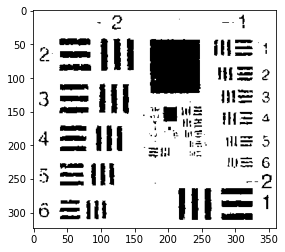

Number of white pixel on the difference image : 2297

We can increase T to 200 with 190 iterations we have : 

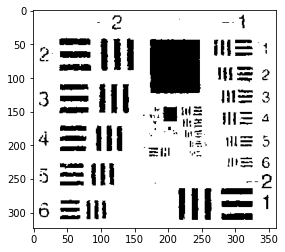

Number of white pixel on the difference image : 2240


To get total convergence we will need to increase a lot T and slowly descrease it to reach small value.


We can compare with other initialisation, for exemple white image for T=200 and 190 iterations ($β'=1000$) :

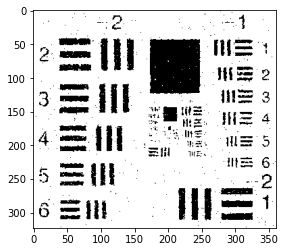

Number of white pixel on the difference image : 2805

The result is not the same because the algorithm is not converging completly with too small T, if we do the test with higher T we will have the same final result no matter the initialisation.